<a href="https://colab.research.google.com/github/Claudia-Cabrera/machine-learning-for-business-analytics/blob/main/Preparing%26Exploring_TimeSeriesData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.signal import detrend



# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import data

# daily births
Daily_Birth = pd.read_csv('/content/drive/MyDrive/Machine Learning/Daily_Birth.csv')

# PRSA_Changping.csv
PRSA_Changping = pd.read_csv('/c3ontent/drive/MyDrive/Machine Learning/PRSA_Changping.csv')

# Question 1
To answer this question, you will need to download the DAILY_BIRTHS data set.  This data set contains the number of daily births in Quebec, Canada from January 1, 1977 to Dec 31, 1990.  You will use the techniques that we have learned in class to practice accumulating, indexing and plotting a time series.

In [ ]:
# view daily births
Daily_Birth.head()

,Date,Num_Births
0,1977-01-01,208
1,1977-01-02,241
2,1977-01-03,274
3,1977-01-04,256
4,1977-01-05,294


In [ ]:
# check data types
print(Daily_Birth.dtypes)

Date          object
Num_Births     int64
dtype: object


## Part a
Create a monthly time series for the total number of births occurring each month.  Produce a time plot of the series and copy and paste the plot below. (time index = month, aggregation method = total)

In [ ]:
# Create year variable
Daily_Birth['year'] = pd.DatetimeIndex(Daily_Birth['Date']).year

# Create month variable
Daily_Birth['month'] =  pd.DatetimeIndex(Daily_Birth['Date']).month

In [ ]:
# Group by month and year
Month_Births = Daily_Birth.groupby(['year', 'month'])['Num_Births'].sum().reset_index()

print(Month_Births.head())

# Create a monthly index
Month_Births['date'] = pd.to_datetime(Month_Births['year'].astype(str) + '-' + Month_Births['month'].astype(str), format="%Y-%m")
births_ts = pd.Series(Month_Births['Num_Births'].values, index= Month_Births['date'])
births_ts.index.freq = 'MS'

   year  month  Num_Births
0  1977      1        8000
1  1977      2        7446
2  1977      3        8682
3  1977      4        8477
4  1977      5        8683


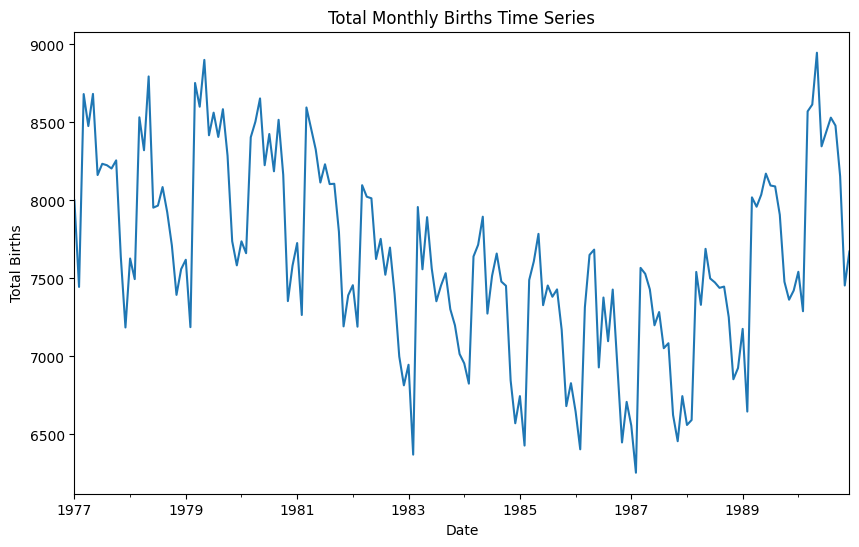

In [ ]:
#Plot the monthly series
plt.figure(figsize=(10, 6))
births_ts.plot()
plt.title("Total Monthly Births Time Series")
plt.xlabel("Date")
plt.ylabel("Total Births")
plt.show()

## Part b
Create a yearly time series for the average number of births occurring each year.  Produce a time plot of the series and copy and paste the plot below. (time index = year, aggregation method = average)

In [ ]:
# Group by year
births_yr = Daily_Birth.groupby(['year'])['Num_Births'].mean().reset_index()

# Create a yearly index for the series
births_yr['date'] = pd.to_datetime(births_yr['year'].astype(str), format="%Y")
births_yr_ts = pd.Series(births_yr['Num_Births'].values, index=births_yr['date'])
births_yr_ts.index.freq = 'YS'

# Plot
plt.figure(figsize=(10, 6))
births_yr_ts.plot()
plt.title("Average Births by Year (Time Series)")
plt.xlabel("Year")
plt.ylabel("Average Number of Births")
plt.show()


NameError: name 'Daily_Birth' is not defined

# Question 2
In this question, you will be exploring a real data set in preparation for modeling.  The data set includes hourly air pollution information from the nationally controlled Changping air-quality monitoring site in China.  The data were provided by the Beijing Municipal Environmental Monitoring Center.  The meteorological data are sourced from the weather station nearest the monitoring site and were provided by the China Meteorological Administration.  The data are from the time period March 1, 2013 to February 28, 2017.  Missing data are denoted as NA.

In [ ]:
# view data
PRSA_Changping.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping
1,2,2013,3,1,1,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Changping
2,3,2013,3,1,2,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Changping
3,4,2013,3,1,3,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Changping
4,5,2013,3,1,4,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Changping


## Part a
Read the PRSA_Changping.csv file into Python.  Are there any missing values present in the data?

In [ ]:
# number of missing values
missing_values = PRSA_Changping.isnull().sum()
print(missing_values)

No            0
year          0
month         0
day           0
hour          0
PM2.5       774
PM10        582
SO2         628
NO2         667
CO         1521
O3          604
TEMP         53
PRES         50
DEWP         53
RAIN         51
wd          140
WSPM         43
station       0
dtype: int64


## Part b
Your ultimate goal with these data is to produce a monthly forecast of the total NO2 concentration at the Changping air quality monitoring station.  With this in mind, you will need to accumulate the data using a monthly time index before continuing with your analysis.  Print out the first few rows of the monthly data series and copy and paste them below.

In [ ]:
# Accumulate the data to a monthly level

# Drop missing values and group by year and month
PRSA_clean = PRSA_Changping.dropna()
PRSA_month = PRSA_clean.groupby(['year', 'month'])['NO2'].sum().reset_index()

print(PRSA_month.head())

# Create a monthly index
PRSA_month['date'] = pd.to_datetime(PRSA_month['year'].astype(str) + '-' + PRSA_month['month'].astype(str), format="%Y-%m")
PRSA_ts = pd.Series(PRSA_month['NO2'].values, index=PRSA_month['date'])
PRSA_ts.index.freq = 'MS'

   year  month         NO2
0  2013      3  42031.0000
1  2013      4  24932.9939
2  2013      5  25057.0000
3  2013      6  10888.0000
4  2013      7  15497.0000


## Part c
Using the monthly series that you created in part (b), generate a time plot of data.  Copy and paste the plot below.  How would you describe this series (e.g., are there any outstanding features of the series – outliers, trend, seasonality)?  

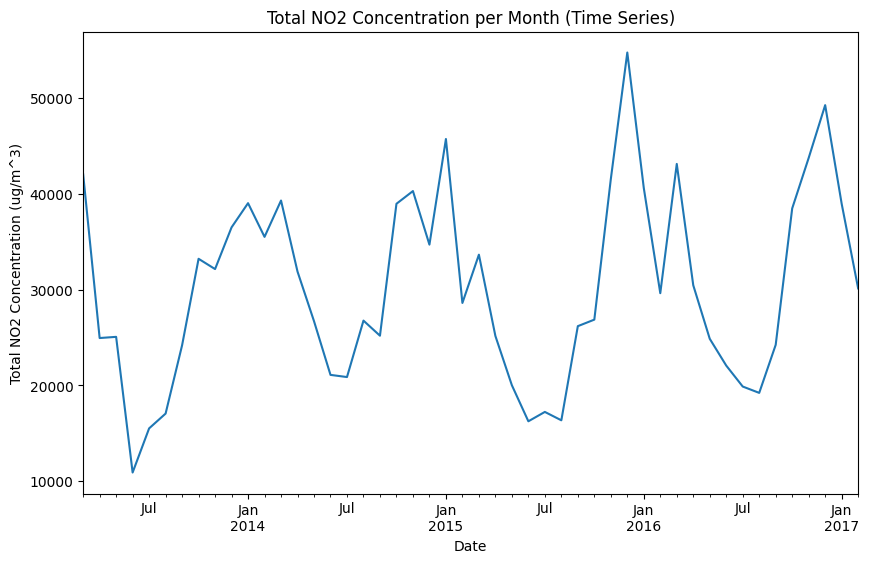

In [ ]:
# Plot the monthly series
plt.figure(figsize=(10, 6))
PRSA_ts.plot()
plt.title("Total NO2 Concentration per Month (Time Series)")
plt.xlabel("Date")
plt.ylabel("Total NO2 Concentration (ug/m^3)")
plt.show()

## Part d
Is this a white noise series?  Paste the relevant output from Python below.  Be sure to state your hypotheses along with your conclusion.

In [ ]:
# execute the Ljung Box test on the NO2 series using 10 lags
PRSAseries = PRSA_clean[['NO2']]
sm.stats.acorr_ljungbox(PRSAseries, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,147064.404721,0.0


## Part e
Generate plots of the autocorrelation function and the partial autocorrelation function for this series.  Copy and paste the plots below.  What do you learn about the series by looking at these plots?

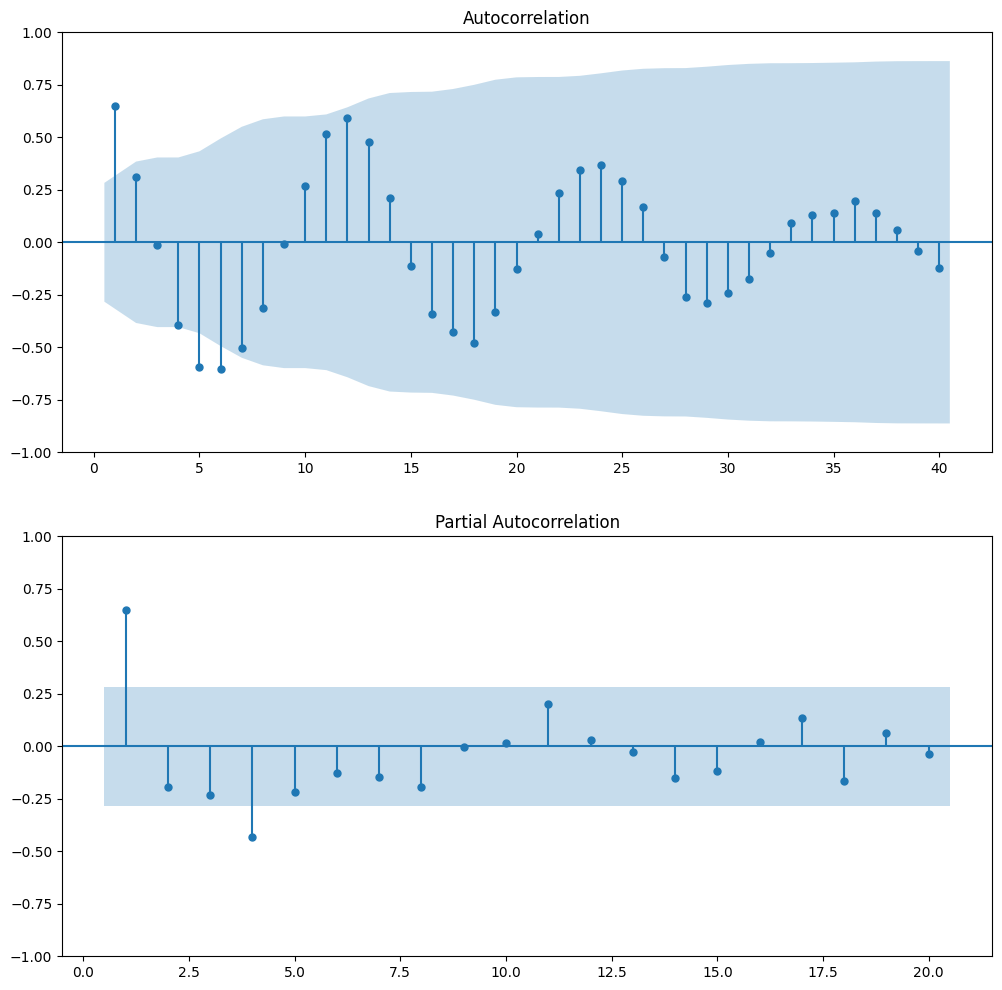

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(PRSA_ts, ax=ax1, zero=False, lags=40)
plot_pacf(PRSA_ts, ax=ax2, zero=False, lags=20)
plt.show()

## Part f
Is this series stationary?  Paste the relevant output from Python below.  Be sure to state your hypotheses along with your conclusion.

- Ho: Series NOT stationary
- Ha: Series is Stationary


In [ ]:
# Dickey Fuller (single mean version)
adfuller(PRSA_ts, regression='c')

(-4.54423795345528,
 0.00016344810368032521,
 6,
 41,
 {'1%': -3.60098336718852,
  '5%': -2.9351348158036012,
  '10%': -2.6059629803688282},
 266.5986039366149)